In [47]:
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor

Load Data - Need to reset index for x_new_train because the index numbers are all messed up from being randomly pulled from a larger sample

In [117]:
spectra_train = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/y_new_train.joblib')
spectra_test = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/y_test.joblib')
labels_train = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/x_new_train.joblib').reset_index()
labels_test = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/x_test.joblib').reset_index()
labels_train_smaller = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/x_train.joblib').reset_index()
spectra_train_smaller = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/y_train.joblib')


,index,Geometry_TriangPrismIsosc,Geometry_parallelepiped,Geometry_sphere,Geometry_wire,Material_Au,Material_SiN,Material_SiO2,log Area/Vol,ShortestDim,MiddleDim,LongDim
0,21317,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.785575,0.05,0.55,4.71
1,33256,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.412331,0.75,2.78,2.78
2,3779,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.523726,0.90,8.29,21.49
3,33130,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.795989,1.93,1.93,13.88
4,2499,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.962482,0.08,0.56,1.26
...,...,...,...,...,...,...,...,...,...,...,...,...
7807,1870,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.412746,0.17,0.48,0.48
7808,914,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.329279,0.51,1.37,1.37
7809,4435,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.016808,0.66,2.06,2.26
7810,14114,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.335932,0.09,0.68,0.68


Define functions used for building the model and parsing datasets

In [ ]:
def preliminary_NN(xtrain, ytrain, xtest, ytest, num_catagories):
    # Xtrain and xtest should be spectra while ytrain and ytest should be specifications of materials 
    # num_catagories (int) should be the number of options availble for the catagorical variable being predicted (ie 3 for 
    # material type since there are 3 materials)
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(400,)))
    model.add(Dense(num_catagories, activation='softmax'))
    model.summary()
    
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    history = model.fit(xtrain, ytrain,
                    batch_size=100,
                    epochs=10,
                    verbose=2,
                    validation_data=(xtest, ytest))

In [13]:
def drop_indicies(df, column, condition_to_drop, update_existing_file = True):
    df_condition = df[column] == condition_to_drop 
    """
    This function takes a pandas df as input and drops a series of rows depending on a specified condition. For example, use this
    function to search through x_train and drop all rows where the material is not gold. 
    
    df - pandas dataframe 
    column - STR the column of the dataframe you want to use to determine if a row should be dropped 
    condition_to_drop - choose condition_to_drop such that the expression evalutes to true for the condition you want dropped 
    (ie if I want to only have Au samples, my column would be Material_Au and my condition would be 0, so that when the 
    condition would be true if the material was not gold)
    update_existing_file - BOOL, determines if the df that is inputted to this function is updated or if a new df with only the
    columns that aren't dropped by this function 
    """
    indicies_to_drop_list = []
    for row in df_condition.index:
        if df_condition.iloc[row] == True:
            indicies_to_drop_list.append(row)
    
    if update_existing_file == True:
        df.drop(indicies_to_drop_list, inplace=update_existing_file)
        return indicies_to_drop_list
    if update_existing_file == False:
        df_new = df.drop(indicies_to_drop_list, inplace=update_existing_file)
        return (df_new, indicies_to_drop_list)
        

Train model to predict the material of the particle corresponding to a spectrum 

In [14]:
labels_train_material = labels_train.drop(columns = ['log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index'] )
labels_test_material = labels_test.drop(columns = ['log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index'] )

In [65]:
labels_train_material_as_array = labels_train_material.to_numpy()
print(labels_train_material_as_array)
labels_test_material_as_array = labels_test_material.to_numpy()

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [146]:
preliminary_NN(spectra_train, labels_train_material_as_array, spectra_test, labels_test_material_as_array, 3)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               205312    
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 1539      
Total params: 206,851
Trainable params: 206,851
Non-trainable params: 0
_________________________________________________________________
Train on 164052 samples, validate on 7813 samples
Epoch 1/10
164052/164052 - 6s - loss: 0.0197 - accuracy: 0.9992 - val_loss: 0.0689 - val_accuracy: 0.9994
Epoch 2/10
164052/164052 - 5s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9997
Epoch 3/10
164052/164052 - 5s - loss: 3.9521e-04 - accuracy: 1.0000 - val_loss: 3.8173e-08 - val_accuracy: 1.0000
Epoch 4/10
164052/164052 - 5s - loss: 9.0534e-09 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9996
Epoch 5/10
164052/16405

I got an accuracy of 1.0000

Train model to predict the shape of the particle corresponding to a spectrum 

In [16]:
labels_train_shape = labels_train.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Material_Au', 
                                                    'Material_SiN', 'Material_SiO2', 'index'] )
labels_test_shape = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Material_Au',
                                                    'Material_SiN', 'Material_SiO2', 'index'] )

labels_train_shape_as_array = labels_train_shape.to_numpy()
labels_test_shape_as_array = labels_test_shape.to_numpy()

In [155]:
preliminary_NN(spectra_train, labels_train_shape_as_array, spectra_test, labels_test_shape_as_array, 4)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 512)               205312    
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 2052      
Total params: 207,364
Trainable params: 207,364
Non-trainable params: 0
_________________________________________________________________
Train on 164052 samples, validate on 7813 samples
Epoch 1/10
164052/164052 - 6s - loss: 0.8693 - accuracy: 0.5908 - val_loss: 1.0397 - val_accuracy: 0.4894
Epoch 2/10
164052/164052 - 5s - loss: 0.7536 - accuracy: 0.6385 - val_loss: 1.1194 - val_accuracy: 0.4748
Epoch 3/10
164052/164052 - 5s - loss: 0.7208 - accuracy: 0.6531 - val_loss: 1.0278 - val_accuracy: 0.5266
Epoch 4/10
164052/164052 - 5s - loss: 0.6997 - accuracy: 0.6619 - val_loss: 0.9537 - val_accuracy: 0.5531
Epoch 5/10
164052/164052 - 5s - los

I ran this a couple times with different set ups and my best model was around 57% accuracy

Train model to predict the shape of the particle corresponding to a spectrum for ONLY GOLD

In [118]:
labels_train_shape_Au = labels_train.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                    'Material_SiN', 'Material_SiO2'] )
labels_test_shape_Au = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                    'Material_SiN', 'Material_SiO2'] )
indicies_to_drop_train_list = drop_indicies(labels_train_shape_Au, 'Material_Au', 0, True)
indicies_to_drop_test_list = drop_indicies(labels_test_shape_Au, 'Material_Au', 0, True)

In [119]:
labels_train_shape_Au.drop(columns = ['Material_Au'] , inplace=True)
labels_test_shape_Au.drop(columns = ['Material_Au'] , inplace=True)

spectra_train_df = pd.DataFrame(spectra_train)
spectra_test_df = pd.DataFrame(spectra_test)

spectra_train_df.drop(indicies_to_drop_train_list, inplace=True)
spectra_test_df.drop(indicies_to_drop_test_list, inplace=True)

In [19]:
labels_train_shape_Au_as_array = labels_train_shape_Au.to_numpy()
labels_test_shape_Au_as_array = labels_test_shape_Au.to_numpy()
spectra_train_shape_Au_as_array = spectra_train_df.to_numpy()
spectra_test_shape_Au_as_array= spectra_test_df.to_numpy()

In [152]:
preliminary_NN(spectra_train_shape_Au_as_array, labels_train_shape_Au_as_array, spectra_test_shape_Au_as_array, labels_test_shape_Au_as_array, 4)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               205312    
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 2052      
Total params: 207,364
Trainable params: 207,364
Non-trainable params: 0
_________________________________________________________________
Train on 54950 samples, validate on 2604 samples
Epoch 1/10
54950/54950 - 2s - loss: 1.0649 - accuracy: 0.5310 - val_loss: 1.3469 - val_accuracy: 0.4581
Epoch 2/10
54950/54950 - 2s - loss: 0.9098 - accuracy: 0.5901 - val_loss: 1.3126 - val_accuracy: 0.4343
Epoch 3/10
54950/54950 - 2s - loss: 0.8674 - accuracy: 0.6084 - val_loss: 1.2200 - val_accuracy: 0.4528
Epoch 4/10
54950/54950 - 2s - loss: 0.8426 - accuracy: 0.6185 - val_loss: 1.3035 - val_accuracy: 0.4658
Epoch 5/10
54950/54950 - 2s - loss: 0.8250 -

In [11]:
labels_train_shape_Au_as_array

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

This one I'm pretty surpised by - I tried a couple different models and I never got above 51%, I really thought this would be better than looking at all the materials

In [12]:
rf_Au_model = RandomForestClassifier(n_estimators = 100)
rf_Au_model.fit(spectra_train_shape_Au_as_array, labels_train_shape_Au_as_array)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
rf_Au_model.score(spectra_test_shape_Au_as_array, labels_test_shape_Au_as_array)

0.5841013824884793

In [14]:
rf_Au_model.predict([spectra_test_shape_Au_as_array[0]])

array([[1., 0., 0., 0.]])

In [16]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(spectra_train, labels_train_material_as_array)
rf_model.score(spectra_test, labels_test_material_as_array)

1.0

In [17]:
rf_model_shape = RandomForestClassifier(n_estimators=100)
rf_model_shape.fit(spectra_train, labels_train_shape_as_array)
rf_model_shape.score(spectra_test, labels_test_shape_as_array)

0.6476385511327275

In [20]:
from_one_hot_dict = {(1.,0.,0.,0.) : 0, (0.,1.,0.,0.) : 1, (0.,0.,1.,0.) : 2, (0.,0.,0.,1.) : 3}
from_one_hot_dict_materials = {(1.,0.,0.) : 0, (0.,1.,0.) : 1, (0.,0.,1.) : 2}



def convert_from_one_hot(df_as_array, dictionary):
    catagories_list = []
    for row in df_as_array:
        row_tuple = tuple(row)
        catagories_list.append(dictionary[row_tuple])
    catagories_list_array = np.asarray(catagories_list)
    print('done')
    return catagories_list_array

In [21]:
labels_train_shape_Au_as_array_wo_OHE = convert_from_one_hot(labels_train_shape_Au_as_array, from_one_hot_dict)

done


In [22]:
labels_test_shape_Au_as_array_wo_OHE = convert_from_one_hot(labels_test_shape_Au_as_array, from_one_hot_dict)

done


In [149]:
rf_Au_model_wo_OHE = RandomForestClassifier(n_estimators = 100)
rf_Au_model_wo_OHE.fit(spectra_train_shape_Au_as_array, labels_train_shape_Au_as_array_wo_OHE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [150]:
rf_Au_model_wo_OHE.score(spectra_test_shape_Au_as_array, labels_test_shape_Au_as_array_wo_OHE)

0.6728110599078341

In [304]:
joblib.dump(rf_Au_model_wo_OHE, "rf_Au_model_wo_OHE.joblib")

['rf_Au_model_wo_OHE.joblib']

In [23]:
labels_train_shape_as_array_wo_OHE = convert_from_one_hot(labels_train_shape_as_array, from_one_hot_dict)
labels_test_shape_as_array_wo_OHE = convert_from_one_hot(labels_test_shape_as_array, from_one_hot_dict)

done
done


In [305]:
rf_model_shape_wo_OHE = RandomForestClassifier(n_estimators=100)
rf_model_shape_wo_OHE.fit(spectra_train, labels_train_shape_as_array_wo_OHE)
rf_model_shape_wo_OHE.score(spectra_test, labels_test_shape_as_array_wo_OHE)

0.714322283373864

In [306]:
joblib.dump(rf_model_shape_wo_OHE, "rf_model_shape_wo_OHE.joblib")

['rf_model_shape_wo_OHE.joblib']

41815
41943
39822
40472


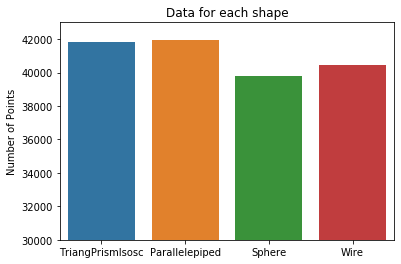

In [24]:
labels_train_shape_wo_OHE = list(labels_train_shape_as_array_wo_OHE)
print(labels_train_shape_wo_OHE.count(0))
print(labels_train_shape_wo_OHE.count(1))
print(labels_train_shape_wo_OHE.count(2))
print(labels_train_shape_wo_OHE.count(3))
data_points_list_shape = [labels_train_shape_wo_OHE.count(0), labels_train_shape_wo_OHE.count(1), labels_train_shape_wo_OHE.count(2),
                         labels_train_shape_wo_OHE.count(3)]
catagories_shape_prediction = ["TriangPrismIsosc", "Parallelepiped", "Sphere", "Wire"]
sns.barplot(catagories_shape_prediction, data_points_list_shape).set(title = "Data for each shape", ylabel = "Number of Points", ylim = [30000,43000])
plt.savefig('Number_of_points_for_each_shape.png', format='png')

54950
54556
54546


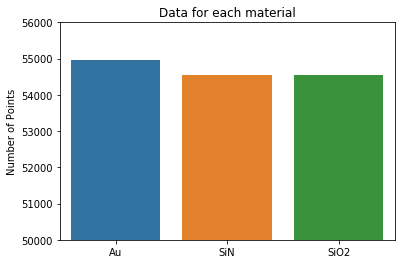

In [67]:
labels_train_shape_wo_OHE = list(labels_train_shape_as_array_wo_OHE)
labels_train_material_wo_OHE = list(labels_train_material_as_array_wo_OHE)
print(labels_train_material_wo_OHE.count(0))
print(labels_train_material_wo_OHE.count(1))
print(labels_train_material_wo_OHE.count(2))
data_points_list_shape = [labels_train_material_wo_OHE.count(0), labels_train_material_wo_OHE.count(1), labels_train_material_wo_OHE.count(2)]
catagories_shape_prediction = ["Au", "SiN", "SiO2"]
sns.barplot(catagories_shape_prediction, data_points_list_shape).set(title = "Data for each material", ylabel = "Number of Points", ylim = [50000,56000])
plt.savefig('Number_of_points_for_each_material.png', format='png')

In [25]:
labels_test_shape_wo_OHE = list(labels_test_shape_as_array_wo_OHE)
print(labels_test_shape_wo_OHE.count(0))
print(labels_test_shape_wo_OHE.count(1))
print(labels_test_shape_wo_OHE.count(2))
print(labels_test_shape_wo_OHE.count(3))

3000
3000
613
1200


In [26]:
predictions = rf_model_shape_wo_OHE.predict(spectra_test)

NameError: name 'rf_model_shape_wo_OHE' is not defined

In [27]:
cm_rf = confusion_matrix(labels_test_shape_wo_OHE, predictions)
print(cm_rf)
def normalize_cm(cm, test_set, num_catagories):
    normalized_list_cm = []
    for i in range(0, num_catagories):
        list_cm = list(cm[i])
        print(test_set.count(i))
        normalized_row_cm = [x /test_set.count(i) for x in  list_cm]
        normalized_list_cm.append(normalized_row_cm)
        
    return normalized_list_cm

cm_normalized_rf = normalize_cm(cm_rf, labels_test_shape_wo_OHE, 4)

NameError: name 'predictions' is not defined

In [265]:
def plot_accuracy(cm, catagories, title, y_range = [0.5,1]):
    accuracies = []
    for i in range(0, len(catagories)):
        print(cm[i][i])
        accuracies.append(cm[i][i])
    sns.barplot(catagories, accuracies).set(title = title, ylabel = "Accuracy", ylim = y_range)
    plt.savefig(str(title) + '.png', format='png')


0.7193333333333334
0.6286666666666667
0.9951060358890701
0.7725


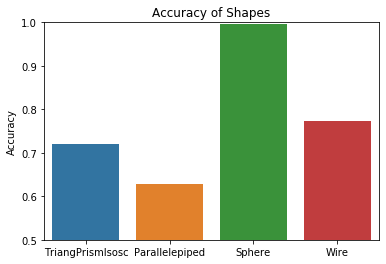

In [309]:
#print(labels_train_shape.columns)
catagories_shape_prediction = ["TriangPrismIsosc", "Parallelepiped", "Sphere", "Wire"]
plot_accuracy(cm_normalized_rf, catagories_shape_prediction, "Accuracy of Shapes")

In [34]:
#rf_model_shape_wo_OHE.n_features_
#features_list = [200,250,300,350,400]
#for feature in features_list:
    

1000
1000
204
400
0.674
0.563
0.9852941176470589
0.775


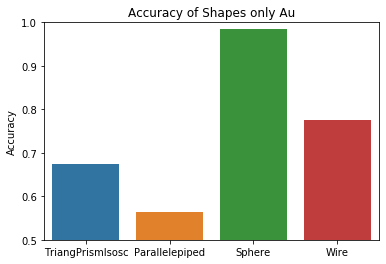

In [310]:
predictions_Au = rf_Au_model_wo_OHE.predict(spectra_test_shape_Au_as_array)

cm_rf_Au = confusion_matrix(labels_test_shape_Au_as_array_wo_OHE, predictions_Au)
labels_test_shape_Au_wo_OHE = list(labels_test_shape_Au_as_array_wo_OHE)
cm_normalized_rf_Au = normalize_cm(cm_rf_Au, labels_test_shape_Au_wo_OHE, 4)
plot_accuracy(cm_normalized_rf_Au, catagories_shape_prediction, "Accuracy of Shapes only Au")

In [36]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 43, 76, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_shape_base = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_shape_random = RandomizedSearchCV(estimator = rf_shape_base, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_shape_random.fit(spectra_train, labels_train_shape_as_array_wo_OHE)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [ ]:
rf_shape_random.best_params_

In [39]:
tree_list = [2,5,10,25,50,100,200,400]   
accuracy_list = []
for tree_num in tree_list:
    rf_model_shape_wo_OHE = RandomForestClassifier(n_estimators=tree_num)
    rf_model_shape_wo_OHE.fit(spectra_train, labels_train_shape_as_array_wo_OHE)
    accuracy_list.append(rf_model_shape_wo_OHE.score(spectra_test, labels_test_shape_as_array_wo_OHE))
    print("done with " + str(tree_num) )
    print("accuracy = " + str(rf_model_shape_wo_OHE.score(spectra_test, labels_test_shape_as_array_wo_OHE)))

done with 2
accuracy = 0.6569819531549981
done with 5
accuracy = 0.6810444131575579
done with 10
accuracy = 0.6967874056060412
done with 25
accuracy = 0.7095865864584666
done with 50
accuracy = 0.7162421605017278
done with 100
accuracy = 0.7145782669909125
done with 200
accuracy = 0.7167541277358249
done with 400
accuracy = 0.7159861768846794


In [52]:
labels_train_smaller_shape = lables_train_smaller.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                    'Material_SiN', 'Material_SiO2', 'Material_Au'] )
lables_train_smaller_shape_as_array = np.asarray(labels_train_smaller_shape)

In [54]:
lables_train_smaller_shape_as_array

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [55]:
lables_train_smaller_shape_as_array_wo_OHE = convert_from_one_hot(lables_train_smaller_shape_as_array,from_one_hot_dict)

done


In [56]:
lables_train_smaller_shape_as_array_wo_OHE

array([1, 3, 0, ..., 0, 1, 1])

In [60]:
labels_train_smaller_shape_wo_OHE = list(lables_train_smaller_shape_as_array_wo_OHE)
print(labels_train_smaller_shape_wo_OHE.count(0))
print(labels_train_smaller_shape_wo_OHE.count(1))
print(labels_train_smaller_shape_wo_OHE.count(2))
print(labels_train_smaller_shape_wo_OHE.count(3))

3000
3000
612
1200


In [83]:
rf_shape_smaller_wo_OHE = RandomForestClassifier(n_estimators = 50, bootstrap = False)
rf_shape_smaller_wo_OHE.fit(spectra_train_smaller, lables_train_smaller_shape_as_array_wo_OHE)
rf_shape_smaller_wo_OHE.score(spectra_test, labels_test_shape_as_array_wo_OHE)

0.7121464226289518

In [67]:
rf_shape_smaller_wo_OHE = RandomForestClassifier(n_estimators = 50)


print(cross_val_score(rf_shape_smaller_wo_OHE, spectra_train_smaller, lables_train_smaller_shape_as_array_wo_OHE, cv=10))

[0.67007673 0.71099744 0.67221511 0.70934699 0.69398207 0.6709347
 0.69398207 0.66453265 0.70678617 0.69654289]


In [79]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100, 1000, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50], 'max_features': ['auto', 'sqrt'], 'max_depth': [100, 190, 280, 370, 460, 550, 640, 730, 820, 910, 1000, None], 'min_samples_split': [10, 20, 30], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [80]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_shape_base = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_shape_random = RandomizedSearchCV(estimator = rf_shape_base, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_shape_random.fit(spectra_train_smaller, lables_train_smaller_shape_as_array_wo_OHE)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  8.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [85]:
#rf_shape_random.best_params_
best_random = rf_shape_random.best_estimator_
best_random.score(spectra_train_smaller, lables_train_smaller_shape_as_array_wo_OHE)

0.9962877624167946

In [82]:
rf_shape_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

Test how accurate a generic RF model is at predicting whether a spectrum is/isn't a particular shape 

In [78]:
def shape_classification_binary(training_set_spectrum, training_set_lables, test_set_spectrum, test_set_labels, 
                                num_trees, shapes):
    for shape in shapes: 
        if shape == 'Geometry_parallelepiped':
            labels_train_shape_parallelepiped = labels_train.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_wire', 'Geometry_TriangPrismIsosc'])
            labels_test_shape_parallelepiped = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_wire', 'Geometry_TriangPrismIsosc'])
            labels_train_shape_parallelepiped_as_array = np.asarray(labels_train_shape_parallelepiped) 
            labels_test_shape_parallelepiped_as_array = np.asarray(labels_test_shape_parallelepiped) 

        if shape == 'Geometry_TriangPrismIsosc':
            labels_train_shape_triangle = labels_train.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_wire', 'Geometry_parallelepiped'])
            labels_test_shape_triangle = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_wire', 'Geometry_parallelepiped'])
            
            labels_train_shape_triangle_as_array = np.asarray(labels_train_shape_triangle) 
            labels_test_shape_triangle_as_array = np.asarray(labels_test_shape_triangle) 
            
        if shape == 'Geometry_wire':
            labels_train_shape_wire = labels_train.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_TriangPrismIsosc', 'Geometry_parallelepiped'])
            labels_test_shape_wire = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_TriangPrismIsosc', 'Geometry_parallelepiped'])
            
            labels_train_shape_wire_as_array = np.asarray(labels_train_shape_wire) 
            labels_test_shape_wire_as_array = np.asarray(labels_test_shape_wire) 
        
        if shape == 'Geometry_sphere':
            labels_train_shape_sphere = labels_train.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_wire', 
                                                                             'Geometry_TriangPrismIsosc', 'Geometry_parallelepiped'])
            labels_test_shape_sphere = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_wire', 
                                                                             'Geometry_TriangPrismIsosc', 'Geometry_parallelepiped'])
            labels_train_shape_sphere_as_array = np.asarray(labels_train_shape_sphere) 
            labels_test_shape_sphere_as_array = np.asarray(labels_test_shape_sphere) 
    

    rf_parallelepiped = RandomForestClassifier(n_estimators=num_trees)
    rf_parallelepiped.fit(spectra_train, np.ravel(labels_train_shape_parallelepiped_as_array))
    print("parallelepiped classifier accuracy " + str(rf_parallelepiped.score(spectra_test, labels_test_shape_parallelepiped_as_array))) 

    rf_sphere = RandomForestClassifier(n_estimators=num_trees)
    rf_sphere.fit(spectra_train, np.ravel(labels_train_shape_sphere_as_array))
    print("sphere classifier accuracy " + str(rf_sphere.score(spectra_test, labels_test_shape_sphere_as_array))) 

    
    rf_triangle = RandomForestClassifier(n_estimators=num_trees)
    rf_triangle.fit(spectra_train, np.ravel(labels_train_shape_triangle_as_array))
    print("triangle classifier accuracy " + str(rf_triangle.score(spectra_test, labels_test_shape_triangle_as_array))) 

    
    rf_wire = RandomForestClassifier(n_estimators=num_trees)
    rf_wire.fit(spectra_train, np.ravel(labels_train_shape_wire_as_array))
    print("wire classifier accuracy " + str(rf_wire.score(spectra_test, labels_test_shape_wire_as_array))) 

    return({'parallelepiped': rf_parallelepiped, 'sphere': rf_sphere, 'triangle': rf_triangle, 'wire': rf_wire})
    

In [326]:

labels_test_shape_parallelepiped = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_wire', 'Geometry_TriangPrismIsosc'])
labels_test_shape_parallelepiped_as_array = np.asarray(labels_test_shape_parallelepiped) 

labels_test_shape_triangle = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_wire', 'Geometry_parallelepiped'])
            
labels_test_shape_triangle_as_array = np.asarray(labels_test_shape_triangle) 
            
            
labels_test_shape_wire = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_sphere', 
                                                                             'Geometry_TriangPrismIsosc', 'Geometry_parallelepiped'])
            
labels_test_shape_wire_as_array = np.asarray(labels_test_shape_wire) 
        
            
labels_test_shape_sphere = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 
                                                                             'MiddleDim', 'LongDim', 'Material_SiN', 
                                                                             'Material_SiO2', 'Material_Au', 'Geometry_wire', 
                                                                             'Geometry_TriangPrismIsosc', 'Geometry_parallelepiped'])
labels_test_shape_sphere_as_array = np.asarray(labels_test_shape_sphere) 

In [327]:
joblib.dump(labels_test_shape_parallelepiped_as_array, "Test_set_labels_parallelepiped")
joblib.dump(labels_test_shape_triangle_as_array, "Test_set_labels_triangle")
joblib.dump(labels_test_shape_wire_as_array, "Test_set_labels_wire")
joblib.dump(labels_test_shape_sphere_as_array, "Test_set_labels_sphere")

['Test_set_labels_sphere']

In [84]:
shapes_list = ['Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'Geometry_TriangPrismIsosc']
shapes_list_clean = ['TriangPrism', 'Parallelepiped', 'Sphere',  'Wire']

In [75]:
shape_classification_rf_dict = shape_classification_binary(spectra_train, labels_train, spectra_test, 
                                                           labels_test, 20, shapes_list)

NameError: name 'shape_classification_binary' is not defined

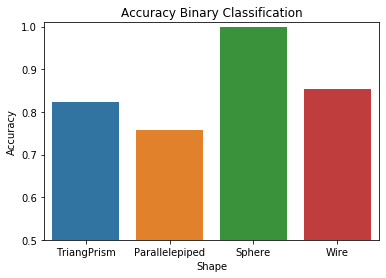

In [87]:
sns.barplot(shapes_list_clean, accuracy_list_binary_classifiction).set(title = "Accuracy Binary Classification",
                                                                                ylabel = "Accuracy", xlabel = "Shape", ylim = [0.5,1.01])
plt.savefig('Accuracy_Binary_Classification_boxplot.png', format='png')

In [86]:
accuracies_binary_classification = {'parallelepiped classifier accuracy': 0.7574555228465378, 'sphere classifier accuracy': 0.9985920901062332,
                 'triangle classifier accuracy': 0.8227313451939076, 'wire classifier accuracy':0.8534493792397286}
accuracy_list_binary_classifiction = [0.8227313451939076, 0.7574555228465378, 0.9985920901062332, 0.8534493792397286]

In [63]:
labels_train_material_as_array_wo_OHE = convert_from_one_hot(labels_train_material_as_array, from_one_hot_dict_materials)

done


In [191]:
print(labels_train_material_as_array_wo_OHE)
print(labels_train_shape_as_array_wo_OHE)
labels_train_material_and_shape_as_array = np.vstack((labels_train_material_as_array_wo_OHE, labels_train_shape_as_array_wo_OHE)).T

[0 2 1 ... 1 0 2]
[3 1 0 ... 0 1 1]


In [192]:
labels_test_material_as_array_wo_OHE = convert_from_one_hot(labels_test_material_as_array, from_one_hot_dict_materials)

done


In [193]:
labels_test_material_and_shape_as_array = np.vstack((labels_test_material_as_array_wo_OHE, labels_test_shape_as_array_wo_OHE)).T

In [205]:
rf_shape_and_material = RandomForestClassifier(n_estimators = 100)
rf_shape_and_material_classifier = MultiOutputClassifier(rf_shape_and_material, n_jobs=-1)
rf_shape_and_material_classifier.fit(spectra_train, labels_train_material_and_shape_as_array)

0.7166261359273006

In [206]:
rf_shape_and_material_classifier.score(spectra_test, labels_test_material_and_shape_as_array)

0.7166261359273006

In [252]:
predictions = rf_shape_and_material_classifier.predict(spectra_test)

In [253]:
predictions.T[0]

array([2, 2, 2, ..., 1, 1, 1])

2604
2604
2605
1.0
0.999231950844854
1.0


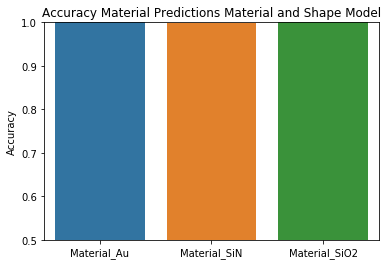

In [284]:
cm_rf_material = confusion_matrix(labels_test_material_as_array_wo_OHE, predictions.T[0])
labels_test_material_wo_OHE=list(labels_test_material_as_array_wo_OHE)
cm_normalized_rf_material = normalize_cm(cm_rf_material, labels_test_material_wo_OHE, 3)
plot_accuracy(cm_normalized_rf, labels_train_material.columns, "Accuracy Material Predictions Material and Shape Model")

In [90]:
cm_rf_shape = confusion_matrix(labels_test_shape_as_array_wo_OHE, predictions.T[1])

labels_test_shape_wo_OHE=list(labels_test_shape_as_array_wo_OHE)
cm_normalized_rf_shape = normalize_cm(cm_rf_shape, labels_test_shape_wo_OHE, 4)

plot_accuracy(cm_normalized_rf_shape, catagories_shape_prediction, "Accuracy Shape Predictions Material and Shape Model")

TypeError: Singleton array 2.997482660388375 cannot be considered a valid collection.

In [293]:
shape_classification_rf_dict.keys()

#binary_classification_list = [shape_classification_rf_dict, accuracies_binary_classification]
joblib.dump(shape_classification_rf_dict, "dictionary_containing_binary_shape_classification_RFs.joblib")

dict_keys(['parallelepiped', 'sphere', 'triangle', 'wire'])

In [ ]:
for key in shape_classification_rf_dict.keys():
    joblib.dump(shape_classification_rf_dict[key], key + "_binary_classifier.joblib")

In [ ]:
joblib.dump(accuracies_binary_classification, 'accuracies_binary_classification.joblib')

In [ ]:
joblib.dump(spectra_test, "Test_set_spectra.joblib")

In [ ]:
labels_train_size_volume = labels_train.drop(columns = ['log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index'] )
labels_test_size_volume = labels_test.drop(columns = ['log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index'] )

In [ ]:
rf_model_material_wo_OHE = RandomForestClassifier(n_estimators=50)
rf_model_material_wo_OHE.fit(spectra_train, labels_train_material_as_array_wo_OHE)
rf_model_material_wo_OHE.score(spectra_test, labels_test_material_as_array_wo_OHE)

In [ ]:
#joblib.dump(rf_model_material_wo_OHE, "rf_model_material_wo_OHE.joblib")
joblib.dump(labels_test_material_as_array_wo_OHE, "labels_test_material_wo_OHE.joblib")

In [ ]:
joblib.dump(rf_shape_and_material_classifier, "rf_shape_and_material_classifier.joblib")

In [ ]:
joblib.dump(labels_test_material_and_shape_as_array, "labels_test_material_and_shape_wo_OHE")

In [ ]:
joblib.dump(spectra_test_shape_Au_as_array, "Test_set_spectra_Au_only")

In [ ]:
joblib.dump(labels_train_shape_Au_as_array_wo_OHE, "Test_set_labels_Au_only")

In [ ]:
joblib.dump(labels_test_shape_as_array, "Test_set_labels_shape")

In [ ]:
joblib.dump(labels_test_material_and_shape_as_array, "Test_set_labels_shape_and_material")

In [291]:
joblib.dump(accuracies_binary_classification, 'accuracies_binary_classification.joblib')

['accuracies_binary_classification.joblib']

In [320]:
joblib.dump(spectra_test, "Test_set_spectra.joblib")

['Test_set_spectra.joblib']

In [313]:
rf_model_material_wo_OHE = RandomForestClassifier(n_estimators=50)
rf_model_material_wo_OHE.fit(spectra_train, labels_train_material_as_array_wo_OHE)
rf_model_material_wo_OHE.score(spectra_test, labels_test_material_as_array_wo_OHE)

1.0

In [319]:
#joblib.dump(rf_model_material_wo_OHE, "rf_model_material_wo_OHE.joblib")
joblib.dump(labels_test_material_as_array_wo_OHE, "labels_test_material_wo_OHE.joblib")

['labels_test_material_wo_OHE.joblib']

In [315]:
joblib.dump(rf_shape_and_material_classifier, "rf_shape_and_material_classifier.joblib")

['rf_shape_and_material_classifier.joblib']

In [318]:
joblib.dump(labels_test_material_and_shape_as_array, "labels_test_material_and_shape_wo_OHE")

['labels_test_material_and_shape_wo_OHE']

In [321]:
joblib.dump(spectra_test_shape_Au_as_array, "Test_set_spectra_Au_only")

['Test_set_spectra_Au_only']

In [322]:
joblib.dump(labels_train_shape_Au_as_array_wo_OHE, "Test_set_labels_Au_only")

['Test_set_labels_Au_only']

In [323]:
joblib.dump(labels_test_shape_as_array, "Test_set_labels_shape")

['Test_set_labels_shape']

In [324]:
joblib.dump(labels_test_material_and_shape_as_array, "Test_set_labels_shape_and_material")

['Test_set_labels_shape_and_material']

In [28]:
labels_train_size_volume = labels_train.drop(columns = ['ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index',
                                                    'Material_Au', 'Material_SiN', 'Material_SiO2'] )
labels_test_size_volume = labels_test.drop(columns = ['ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index',
                                                     'Material_Au', 'Material_SiN', 'Material_SiO2'] )

In [35]:
rf_volume = RandomForestRegressor(n_estimators = 10, n_jobs = -1)
rf_volume.fit(spectra_train, np.ravel(labels_train_size_volume))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [36]:
rf_volume.score(spectra_test, np.ravel(labels_test_size_volume))

0.9733092312919017

In [37]:
predictions = rf_volume.predict(spectra_test)

In [38]:
predictions

array([3.8310645 , 2.99748266, 2.32836699, ..., 3.77872027, 2.69235198,
       4.4481172 ])

In [40]:
np.ravel(labels_test_size_volume)

array([3.83217036, 3.02216553, 2.33523359, ..., 3.78348881, 2.69359616,
       4.43835435])

In [41]:
labels_train_size_volume_dims = labels_train.drop(columns = ['Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index',
                                                    'Material_Au', 'Material_SiN', 'Material_SiO2'] )
labels_test_size_volume_dims = labels_test.drop(columns = ['Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index',
                                                     'Material_Au', 'Material_SiN', 'Material_SiO2'] )

In [45]:
labels_train_size_volume_dims_array = np.asarray(labels_train_size_volume_dims)
labels_test_size_volume_dims_array = np.asarray(labels_test_size_volume_dims)

In [48]:
rf_volume_size = RandomForestRegressor(n_estimators = 10)
rf_volume_size_multioutput = MultiOutputRegressor(rf_volume_size, n_jobs = -1)
rf_volume_size_multioutput.fit(spectra_train, labels_train_size_volume_dims_array)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10,
                                                     n_jobs=None,
                                                     oob_score=False,
                                                  

In [49]:
rf_volume_size_multioutput.score(spectra_test, labels_test_size_volume_dims_array)

0.8975875362612722

In [50]:
rf_volume_size_more_trees = RandomForestRegressor(n_estimators = 50)
rf_volume_size_multioutput_more_trees = MultiOutputRegressor(rf_volume_size_more_trees, n_jobs = -1)
rf_volume_size_multioutput_more_trees.fit(spectra_train, labels_train_size_volume_dims_array)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10,
                                                     n_jobs=None,
                                                     oob_score=False,
                                                  

In [51]:
rf_volume_size_multioutput_more_trees.score(spectra_test, labels_test_size_volume_dims_array)

0.8925285870088243

In [53]:
labels_train_size_dims = labels_train.drop(columns = ['Geometry_TriangPrismIsosc','log Area/Vol',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index',
                                                    'Material_Au', 'Material_SiN', 'Material_SiO2'] )
labels_test_size_dims = labels_test.drop(columns = ['Geometry_TriangPrismIsosc','log Area/Vol',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index',
                                                     'Material_Au', 'Material_SiN', 'Material_SiO2'] )

In [54]:
rf_size_dims = RandomForestRegressor(n_estimators = 10)
rf_size_dims_mulitoutput = MultiOutputRegressor(rf_volume_size, n_jobs = -1)
rf_size_dims_mulitoutput.fit(spectra_train, labels_train_size_dims)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10,
                                                     n_jobs=None,
                                                     oob_score=False,
                                                  

In [55]:
labels_train_size_dims_as_array = np.asarray(labels_train_size_dims)
labels_test_size_dims_as_array = np.asarray(labels_test_size_dims)

In [58]:
rf_size_dims_mulitoutput.score(spectra_test, labels_test_size_dims_as_array)

0.868801427839477

In [127]:
labels_train_shape_SiN = labels_train.drop(columns = ['index','Material_Au','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                     'Material_SiO2'] )
labels_test_shape_SiN = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                    'Material_Au', 'Material_SiO2'] )
indicies_to_drop_train_list_SiN = drop_indicies(labels_train_shape_SiN, 'Material_SiN', 0, True)
indicies_to_drop_test_list_SiN = drop_indicies(labels_test_shape_SiN, 'Material_SiN', 0, True)

labels_train_shape_SiN.drop(columns = ['Material_SiN'] , inplace=True)
labels_test_shape_SiN.drop(columns = ['Material_SiN'] , inplace=True)

spectra_train_df_SiN = pd.DataFrame(spectra_train)
spectra_test_df_SiN = pd.DataFrame(spectra_test)

spectra_train_df_SiN.drop(indicies_to_drop_train_list_SiN, inplace=True)
spectra_test_df_SiN.drop(indicies_to_drop_test_list_SiN, inplace=True)

labels_train_shape_SiN_as_array = labels_train_shape_SiN.to_numpy()
labels_test_shape_SiN_as_array = labels_test_shape_SiN.to_numpy()

labels_train_shape_SiN_as_array_wo_OHE = convert_from_one_hot(labels_train_shape_SiN_as_array, from_one_hot_dict)
labels_test_shape_SiN_as_array_wo_OHE =  convert_from_one_hot(labels_test_shape_SiN_as_array, from_one_hot_dict)

spectra_train_shape_SiN_as_array = spectra_train_df_SiN.to_numpy()
spectra_test_shape_SiN_as_array= spectra_test_df_SiN.to_numpy()

done
done


In [128]:
rf_SiN_model_wo_OHE = RandomForestClassifier(n_estimators = 100)
rf_SiN_model_wo_OHE.fit(spectra_train_shape_SiN_as_array, labels_train_shape_SiN_as_array_wo_OHE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [129]:
rf_SiN_model_wo_OHE.score(spectra_test_shape_SiN_as_array, labels_test_shape_SiN_as_array_wo_OHE)

0.7549923195084486

In [137]:
labels_train_shape_SiO2 = labels_train.drop(columns = ['index','Material_Au','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                     'Material_SiN'] )
labels_test_shape_SiO2= labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                    'Material_Au', 'Material_SiN'] )
indicies_to_drop_train_list_SiO2 = drop_indicies(labels_train_shape_SiO2, 'Material_SiO2', 0, True)
indicies_to_drop_test_list_SiO2 = drop_indicies(labels_test_shape_SiO2, 'Material_SiO2', 0, True)

labels_train_shape_SiO2.drop(columns = ['Material_SiO2'] , inplace=True)
labels_test_shape_SiO2.drop(columns = ['Material_SiO2'] , inplace=True)

spectra_train_df_SiO2 = pd.DataFrame(spectra_train)
spectra_test_df_SiO2 = pd.DataFrame(spectra_test)

spectra_train_df_SiO2.drop(indicies_to_drop_train_list_SiO2, inplace=True)
spectra_test_df_SiO2.drop(indicies_to_drop_test_list_SiO2, inplace=True)

labels_train_shape_SiO2_as_array = labels_train_shape_SiO2.to_numpy()
labels_test_shape_SiO2_as_array = labels_test_shape_SiO2.to_numpy()

labels_train_shape_SiO2_as_array_wo_OHE = convert_from_one_hot(labels_train_shape_SiO2_as_array, from_one_hot_dict)
labels_test_shape_SiO2_as_array_wo_OHE =  convert_from_one_hot(labels_test_shape_SiO2_as_array, from_one_hot_dict)

spectra_train_shape_SiO2_as_array = spectra_train_df_SiO2.to_numpy()
spectra_test_shape_SiO2_as_array= spectra_test_df_SiO2.to_numpy()

print(len(labels_train_shape_SiO2_as_array_wo_OHE))
print(len(spectra_train_shape_SiO2_as_array))

done
done
54546
54546


In [138]:
rf_SiO2_model_wo_OHE = RandomForestClassifier(n_estimators = 100)
rf_SiO2_model_wo_OHE.fit(spectra_train_shape_SiO2_as_array, labels_train_shape_SiO2_as_array_wo_OHE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [139]:
rf_SiO2_model_wo_OHE.score(spectra_test_shape_SiO2_as_array, labels_test_shape_SiO2_as_array_wo_OHE)

0.7393474088291747

In [145]:
rf_SiO2_model_wo_OHE.score(spectra_test_shape_SiN_as_array, labels_test_shape_SiN_as_array_wo_OHE)

0.07834101382488479

In [144]:
rf_SiO2_model_wo_OHE.score(spectra_test_shape_Au_as_array, labels_test_shape_Au_as_array_wo_OHE)

0.07834101382488479

In [146]:
rf_SiN_model_wo_OHE.score(spectra_test_shape_SiO2_as_array, labels_test_shape_SiO2_as_array_wo_OHE)

0.32092130518234163

In [147]:
rf_SiN_model_wo_OHE.score(spectra_test_shape_Au_as_array, labels_test_shape_Au_as_array_wo_OHE)

0.34639016897081415

In [151]:
rf_Au_model_wo_OHE.score(spectra_test_shape_Au_as_array, labels_test_shape_Au_as_array_wo_OHE)

0.6728110599078341

In [152]:
rf_Au_model_wo_OHE.score(spectra_test_shape_SiN_as_array, labels_test_shape_SiN_as_array_wo_OHE)

0.1390168970814132

In [153]:
rf_Au_model_wo_OHE.score(spectra_test_shape_SiO2_as_array, labels_test_shape_SiO2_as_array_wo_OHE)

0.13051823416506717